In [2]:
%load_ext autoreload

%autoreload 2

from medcat.cat import CAT
from medcat.utils.vocab import Vocab
from medcat.cdb import CDB
from medcat.prepare_cdb import PrepareCDB

from reconcile import map_medcat_annos_to_icd9, remove_duplicate_mapped_assigned_codes

from icd9cms import search
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import json
from matplotlib import pyplot as plt
import seaborn as sns
import scipy

In [66]:
codes.shape[0]

634709

In [65]:
joined_df_fine_tuned.shape

(484744, 10)

In [353]:
codes = pd.read_csv('data/admission_codes.csv')
df = codes.groupby('icd9_code').count()
df.reset_index(inplace=True)
df.columns = ['cui', 'count', '_', '_']
clean_codes = df.loc[:, ['cui', 'count']]

### Top 5 Occurring Codes in MIMIC-III

In [13]:
clean_codes.sort_values('count', ascending=False).head(5)

,cui,count
1920,4019,20703
2066,4280,13111
2055,42731,12891
1977,41401,12429
2897,5849,9119


In [14]:
# needed columns 
# cui,str,onto,tty,tui,sty,desc,is_unique,examples
code_meta_dir = defaultdict(list)
for row in clean_codes.itertuples():
    found_code = search(row.cui)
    code_meta_dir['cui'].append(row.cui)
    code_meta_dir['count'].append(row.count)
    code_meta_dir['str'].append(found_code.short_desc)
    code_meta_dir['onto'].append('icd9')
    parent_code = found_code
    if  found_code.code[0] != 'E' and len(found_code.code) > 3:
        parent_code = search(found_code.code[0:3])
    elif found_code.code[0] == 'E' and len(found_code.code) > 4:
        parent_code = search(found_code.code[0:4])
    code_meta_dir['tui'].append(parent_code.code)
    code_meta_dir['sty'].append(parent_code.short_desc)
    code_meta_dir['desc'].append(found_code.long_desc or found_code.short_desc)
    code_meta_dir['is_unique'].append(-1)

In [15]:
cdb_df = pd.DataFrame(code_meta_dir).sort_values('count', ascending=False)

In [16]:
cdb_df.sort_values('count', ascending=False).head(10)

,cui,count,str,onto,tui,sty,desc,is_unique
1920,4019,20703,Hypertension NOS,icd9,401,Essential hypertension,Unspecified essential hypertension,-1
2066,4280,13111,CHF NOS,icd9,428,Heart failure,"Congestive heart failure, unspecified",-1
2055,42731,12891,Atrial fibrillation,icd9,427,Cardiac dysrhythmias,Atrial fibrillation,-1
1977,41401,12429,Crnry athrscl natve vssl,icd9,414,Other forms of chronic ischemic heart disease,Coronary atherosclerosis of native coronary ar...,-1
2897,5849,9119,Acute kidney failure NOS,icd9,584,Acute kidney failure,"Acute kidney failure, unspecified",-1
811,25000,9058,DMII wo cmp nt st uncntr,icd9,250,Diabetes mellitus,Diabetes mellitus without mention of complicat...,-1
931,2724,8690,Hyperlipidemia NEC/NOS,icd9,272,Disorders of lipoid metabolism,Other and unspecified hyperlipidemia,-1
2484,51881,7497,Acute respiratry failure,icd9,518,Other diseases of lung,Acute respiratory failure,-1
2965,5990,6555,Urin tract infection NOS,icd9,599,Other disorders of urethra and urinary tract,"Urinary tract infection, site not specified",-1
2576,53081,6326,Esophageal reflux,icd9,530,Diseases of esophagus,Esophageal reflux,-1


## Link Pre-trained UMLS to ICD-9-CM
CSV mapping file from: https://bioportal.bioontology.org/ontologies/ICD9CM/?p=summary

After testing with ICD9 mapping. Many mappings appear to be missing with UMLS. Using the trained / built ICD10 to UMLS mapping

In [7]:
# mapping = pd.read_csv('ICD9CM.csv')

## Mapping ICD9 to ICD10

In [17]:
codes = pd.read_csv('data/admission_codes.csv')

In [18]:
icd9_to_10_mapping = pd.read_csv('refdata/icd9toicd10cmgem.csv')
sorted_codes = codes.icd9_code.value_counts().reset_index().sort_values('icd9_code', ascending=False)
sorted_codes.columns = ['code', 'count']
count = 0
icd10 = []
for c in sorted_codes.code:
    mapped_rows = icd9_to_10_mapping[icd9_to_10_mapping.icd9cm == c]   
    icd10.append(','.join(mapped_rows.icd10cm.tolist()) if 
                 mapped_rows.shape[0] > 1 else mapped_rows.icd10cm.iloc[0])
sorted_codes['icd10'] = icd10

In [19]:
total_assigned_codes = sorted_codes['count'].sum()

In [20]:
sorted_codes['count'].iloc[:300].sum()

450732

## Code Proportions of Total Assigned Codes
We go with thea top 400 ICD-9 codes in the following analysis, giving  is a reasonable number for 'majority' coverage of the codes in MIMIC-III without validating all ~6k. 

In [21]:
code_ranges = [50, 100, 200, 300, 400, 500, 600]
props_of_total_codes = [(r, round((sorted_codes['count'].iloc[:r].sum() / total_assigned_codes) * 100, 2)) for r in code_ranges] 

In [22]:
props_of_total_codes

[(50, 38.24),
 (100, 50.11),
 (200, 63.39),
 (300, 71.01),
 (400, 76.2),
 (500, 79.96),
 (600, 82.9)]

## Filter Down to top 400 ICD-9 Codes
That have first been mapped to ICD-10 codes, then mapped to UMLS CUI Codes.

In [23]:
icd10_mapping = pd.read_csv('refdata/UMLS_to_ICD10.csv')

In [24]:
icd10_mapping = icd10_mapping.loc[:, ['Class ID', 'CUI', 'Semantic type UMLS property']]

In [25]:
icd10_mapping['tuis'] = icd10_mapping['Semantic type UMLS property']\
    .str.split('|').dropna().apply(\
        lambda tui_list: ','.join([l.split('/')[-1] for l in tui_list]))

In [26]:
icd10_mapping['code'] = icd10_mapping['Class ID'].str.split('/').apply(lambda l: l[-1])

In [27]:
from itertools import chain
icd10_codes_to_keep = list(chain.from_iterable(sorted_codes[0:400].icd10.str.split(',').tolist()))

In [28]:
icd10_mapping['code'] = icd10_mapping.code.str.replace('.', '')
tuis_to_keep = chain.from_iterable([icd10_mapping[icd10_mapping.code == code].tuis.tolist() for code in icd10_codes_to_keep])
tuis_to_keep = set(chain.from_iterable([tui.split(',') for tui in tuis_to_keep]))
cuis_to_keep = chain.from_iterable([icd10_mapping[icd10_mapping.code == code].CUI.tolist() for code in icd10_codes_to_keep])
cuis_to_keep = list(chain.from_iterable([cui.split('|') for cui in cuis_to_keep]))
cuis_to_keep = list(set(cuis_to_keep))

In [29]:
icd10_mapping = pd.read_csv('refdata/UMLS_to_ICD10.csv')
icd10_mapping['icd10'] = icd10_mapping['Class ID'].str.split('/').apply(lambda l: l[-1])
icd10_mapping['icd10'] = icd10_mapping.icd10.str.replace('.', '')

## Code Reconciliation
Given a set of predicted UMLS concepts for the DD subsections made by MedCAT, we aim to reconcile the codes assigned to the discharge diagnosis subsections in MIMIC-III.

Firstly, we map the predicted codes back into their ICD-9 counterparts. MedCAT already contains a UMLS to ICD-10-CM mapping, so we directly use that mapping supplied by the tool.

In [74]:
notes = pd.read_csv('data/mimic_dd_icd9_sections.csv')
notes['name'] = notes.name.str.split(':').apply(lambda l: l[1])
codes = pd.read_csv('data/admission_codes.csv')
objs = json.load(open('data/mimic_dd_annos.json'))

### Map parsed UMLS concepts with attached ICD-10 codes to ICD9

In [75]:
parsed_dd_mapped_to_icd9 = map_medcat_annos_to_icd9(objs, notes, codes, cuis_to_keep)

### Reconcile Codes
As UMLS codes can map many-to-many to ICD-10 and ICD-9 codes, a single UMLS prediction by MedCAT can map to many associated ICD codes. If the MIMIC-III assigned codes matches one of these UMLS assigned codes we assume the MIMIC-III assigned code is correct and remove all others that refer to the same span of text.

Then split the reconciled codes into 3 datasets:
- Assigned in MIMIC-III and Not Predicted by MedCAT, denoted **A_NP** in the paper.
- Predicted by MedCAT and Assigned in MIMIC-III, denoted **P_A** in the paper. 
- Predicted by MedCAT and Not Assigned in MIMIC-III, denoted **P_NA** in the paper. 

In [76]:
joined_df = remove_duplicate_mapped_assigned_codes(notes, codes, parsed_dd_mapped_to_icd9)

### Plot Base Predictions by MedCAT of DD Susections
- Predicted codes that match with Assigned codes from MIMIC-III
- Predicted codes but have no matching assigned codes. (These are the most interesting cases, where we can begin to argue where the coding is unreliable).
- We accept the gap between assigned codes and no predictions is large due to:
 - codes coming from outside the DD subsection
 - possibly overcoding

In [33]:
def compute_y(joined_df, filter_unvalidated_codes=None):
    matched_codes = joined_df[joined_df.match == 'match'].icd9.unique()
    joined_df_assignedno_pred = joined_df[joined_df.match == 'assigned_no_pred']
    joined_df_assignedno_pred = joined_df_assignedno_pred[joined_df_assignedno_pred.icd9.isin(matched_codes)].shape[0]
    pred_no_assn = joined_df[joined_df.match == 'pred_no_assign']
    matched = joined_df[joined_df.match == 'match']
    
    print(len(matched.icd9.unique()))
    if filter_unvalidated_codes:
        matched = matched[~matched.icd9.isin(filter_unvalidated_codes)]
        pred_no_assn = pred_no_assn[~pred_no_assn.icd9.isin(filter_unvalidated_codes)]

    y = [joined_df[joined_df.match == 'assigned_no_pred'].shape[0],  # raw code counts
         joined_df_assignedno_pred, # raw code counts not including the codes that had at least one match in MedCAT
         matched.shape[0], # raw code counts that match with assigned codes
         pred_no_assn.shape[0] # raw code counts that were not assigned but were predicted.
        ]
    return y

## MedCAT Fine-Tuning / Validation Stratified Sampling 
We sub-sample each of the three datasets by:
 - by ICD-9 Code
 - by HADMD ID

The **A_NP** dataset is used for MedCAT 'fine-tuning', so the model can include additional synoyms or abbreviations for codes.

**P_A** and **P_NA** are used to validate the tool ensuring the model predictions are valid.

In [429]:
random_state = 42
def sample_dataset(dataset, sample_size, num_discard_lead_samples=0, only_sample_codes=None):
    samples = []
    for code, group_df in dataset.groupby('icd9'):
        if only_sample_codes is not None and code not in only_sample_codes:
            continue
        sample_df = group_df.sample(min(group_df.shape[0], sample_size), random_state=random_state).loc[:, ['hadm']]
        sample_df.iloc[num_discard_lead_samples:]
        sample_df['icd9'] = code
        sample_df['text'] = [notes[notes.name == str(sample.hadm)].text.iloc[0] for sample in sample_df.itertuples()]
        samples.append(sample_df)
    return pd.concat(samples).reset_index(drop=True)

### Sample - Prediction and Assigned

In [430]:
sample_dataset(joined_df[joined_df.match == 'match'], 10).to_csv('sampled_correct_preds.csv', index=False)

### Sample - Pred and Not Assigned

In [ ]:
sample_dataset(joined_df[joined_df.match == 'pred_no_assign'], 10).to_csv('sampled_preds_no_assign.csv', index=False)

### Sample - Assigned, No Pred

In [ ]:
sample_dataset(joined_df[joined_df.match == 'assigned_no_pred'], 10).to_csv('sampled_assigned_no_pred.csv', index=False)

# Create Datasets to be evaluated in MedCATTrainer
We use a running instance of the [MedCATTrainer](https://github.com/Cogstack/MedCATTrainer) interface.

We use the ReST API for creating datasets / projects

In [10]:
import requests
import json
import pandas as pd

### First 'Login' to the API with Username and Password.
The returned API token once logged in is used in subsequent request headers.

In [16]:
headers = {
    'Authorization': f'Token {json.loads(requests.post("http://localhost:8001/api/api-token-auth/", json={"username": "admin", "password": "admin"}).text)["token"]}',
}

### Create Datasets for Fine-Tuning / Validation
Each ICD-9 Code for each of the 3 (**A_NP**, **P_A**, **P_NA**) are created.

In [100]:
def create_datasets(filename, dataset_name_prefix, dataset_desc_prefix):
    dataset_ids = []
    for code, group_df in list(pd.read_csv(filename).groupby('icd9')):
        group_df.columns = ['name', 'icd9', 'text']
        payload = {
            'dataset_name': f'{dataset_name_prefix}{code}',
            'dataset': group_df.loc[:, ['name', 'text']].to_dict(),
            'description': f'{dataset_desc_prefix}{code}',
        }
        resp = requests.post('http://localhost:8001/api/create-dataset/', json=payload, headers=headers)
        dataset_ids.append(json.loads(resp.text)['dataset_id'])
    return dataset_ids

In [ ]:
assn_no_pred_dataset_ids = create_datasets('sampled_assigned_no_pred.csv', 'Assn No Pred ', 'Assigned with no prediction for code ')

In [114]:
assn_pred_dataset_ids = create_datasets('sampled_correct_preds.csv', 'Corr No Pred ', 'Assigned and predicted for code ')

In [106]:
preds_no_assgn_dataset_ids = create_datasets('sampled_preds_no_assign.csv', 'Preds No Assn ', 'Predicted but no assignment for code ')

### Create Projects for Fine-Tuning / Validation
Each ICD-9 Code for each of the 3 (**A_NP**, **P_A**, **P_NA**) are created.

We create an associated .csv file for each of 3 datasets to track the manual validation / fine-tuning effort.

In [102]:
icd10_mapping.icd10_code = icd10_mapping.icd10_code.str.replace('.', '')
icd9_to_10_mapping.reset_index(inplace=True)

In [112]:
def create_projects(project_prefix, filename, dataset_ids):
    code_maps = {'icd9_code': [], 'icd9_long_title': [], 'icd10_code': [], 'umls_cuis': []}
    for dataset_id, (code, group_df) in zip(dataset_ids, pd.read_csv(filename).groupby('icd9')):
        icd10_mapped_codes = icd9_to_10_mapping[icd9_to_10_mapping.icd9cm == code].icd10cm.tolist()
        cuis = list(chain.from_iterable([c.split('|') for c in icd10_mapping[icd10_mapping.icd10_code.isin(icd10_mapped_codes)].CUI.tolist()]))
        payload = {
            'name': f'{project_prefix} - DS: {dataset_id} code: {code} desc: {codes[codes.icd9 == code].iloc[0].short_title}',
            'description': '',
            'cuis': ','.join(cuis),
            'tuis': '',
            'require_entity_validation': True,
            'train_model_on_submit': True,
            'dataset': dataset_id,
            'concept_db': 3, # UMLS Full CDB 
            'vocab': 1, # vocab full
            'members': [1]
        }
        code_maps['icd9_code'].append(code)
        code_maps['icd9_long_title'].append(search(code).long_desc)
        code_maps['icd10_code'].append(icd10_mapped_codes)
        code_maps['umls_cuis'].append(cuis)
        resp = requests.post('http://localhost:8001/api/project-annotate-entities/', json=payload, headers=headers)
        if resp.ok:
            print(f'created project for dataset:{dataset_id}')
        else:
            print(f'error creating project for dataset:{dataset_id}')
            print(resp.text)
            raise Exception()
    return code_maps

In [207]:
df = list(pd.read_csv('sampled_assigned_no_pred.csv').groupby('icd9'))
icd9_to_10_mapping[icd9_to_10_mapping.icd9cm == '00845'].icd10cm.tolist()
df = list(pd.read_csv('sampled_correct_preds.csv').groupby('icd9'))

In [252]:
code_maps_asssn_no_preds = create_projects('Assn No Prd', 'sampled_assigned_no_pred.csv', assn_no_pred_dataset_ids)
pd.DataFrame(code_maps_asssn_no_preds).to_csv('code_maps_sampled_assgned_no_pred.csv', index=False)

In [ ]:
code_maps_preds_no_assign = create_projects('Prd N Asn', 'sampled_preds_no_assign.csv', preds_no_assgn_dataset_ids)
pd.DataFrame(code_maps_preds_no_assign).to_csv('code_maps_sampeld_preds_no_assn.csv', index=False)

In [124]:
code_maps_correct_preds = create_projects('Cor Prd', 'sampled_correct_preds.csv', assn_pred_dataset_ids)
pd.DataFrame(code_maps_correct_preds).to_csv('code_maps_sampled_correct_preds.csv', index=False)

## Manual validation of above samples of each Dataset
Each csv dataset has an associated .xlsx, with further columns added for validation.

### Further Samples of Assigned but no prediction from MedCAT
- During validation of the 'Assigned with no prediction of code', we annotate if more samples are required.
- Re-sample only those with 'TRUE' in the column of more_samples_required.

In [422]:
code_maps_assn_no_preds_complete = pd.read_excel('code_maps_sampled_assgned_no_pred.xlsx')

In [425]:
icd9_codes_to_resample = code_maps_assn_no_preds_complete[code_maps_assn_no_preds_complete.more_samples_required].icd9_code.tolist()

In [433]:
sample_dataset(joined_df[joined_df.match == 'assigned_no_pred'], 10, 10, icd9_codes_to_resample).to_csv('sampled_assigned_no_pred_more.csv', index=False)

### Analyse Annotations
Group annotations by top level axis and plot 

In [78]:
def find_root_axis(code): 
    par = code.parent
    if par is not None:
        return find_root_axis(par)
    else:
        return code

In [108]:
assn_no_pred = pd.DataFrame(json.load(open('data/MedCAT_Export_With_Text_Assn_No_Pred.json'))['projects'])
assn_no_pred = assn_no_pred.iloc[:-3]
assn_no_pred['icd9'] = assn_no_pred.loc[:, 'name'].str.split(':').apply(lambda l: l[2].strip().split(' ')[0])

assn_no_pred['root_axis'] = assn_no_pred.icd9.apply(lambda code: find_root_axis(search(code))).apply(str)
assn_no_pred['annotations'] = assn_no_pred.loc[:, 'documents'].apply(lambda docs: [a for d in docs for a in d['annotations']])
assn_no_pred['annos_len'] = assn_no_pred.annotations.apply(len)
annos_by_axis = assn_no_pred.loc[:, ['root_axis', 'annos_len']].groupby('root_axis').sum()
# clean up the axis-names
x_axis_ticks = [s.split(':')[0] for s in annos_by_axis.index]

all_assn_no_pred = joined_df[joined_df.match == 'assigned_no_pred']
all_assn_no_pred['root_axis'] = all_assn_no_pred.icd9.apply(lambda code: find_root_axis(search(code))).apply(str)
all_assn_no_pred = all_assn_no_pred.loc[:, ['icd9', 'root_axis']]
all_assn_no_pred['root_axis'] = all_assn_no_pred.root_axis.str.split(':').apply(lambda l: l[0])
all_assn_no_pred = all_assn_no_pred.groupby('root_axis').count()

<ipython-input-108-54d51beb618b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_assn_no_pred['root_axis'] = all_assn_no_pred.icd9.apply(lambda code: find_root_axis(search(code))).apply(str)


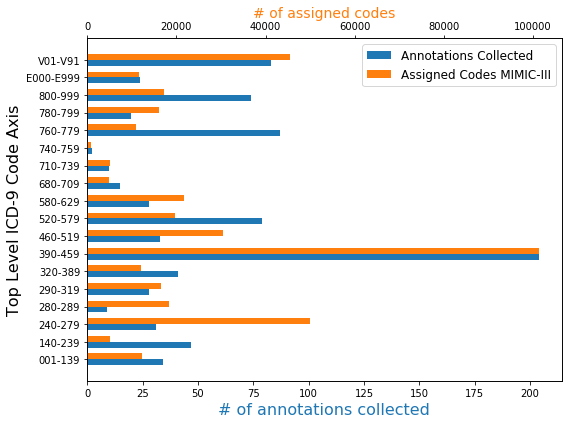

In [109]:
fig, ax = plt.subplots(figsize=(8, 6))
indices = range(len(annos_by_axis.annos_len.tolist()))
width = np.min(np.diff(indices))/3

ax2 = ax.twiny()

color_1 = 'tab:blue'
color_2 = 'tab:orange'

bar1 = ax.barh(indices - width / 2, annos_by_axis.annos_len, width, label='Annotations Collected', color=color_1)
ax.set_yticks(indices)
ax.set_yticklabels(x_axis_ticks)
ax.set_ylabel('Top Level ICD-9 Code Axis', fontsize=16)
ax.set_xlabel('# of annotations collected', color=color_1, fontsize=16)

bar2 = ax2.barh(indices + width / 2, all_assn_no_pred.icd9, width, label='Assigned Codes MIMIC-III', color=color_2)
ax2.set_xlabel('# of assigned codes', color=color_2, fontsize=14)

plt.legend([bar1, bar2], [bar1.get_label(), bar2.get_label()], fontsize=12)
plt.tight_layout()
plt.savefig('./plots/training_data_collected_stacked.png')
plt.show()

### Analysis of Validated Codes
- We keep predictions of codes that have been validated as correctly predicted across all instances for both Predicted, Not Assigned and Predicted, Assigned.

In [41]:
pred_corr_assn = pd.DataFrame(json.load(open('data/MedCAT_Export_With_Text_Pred_Corr.json'))['projects'])
pred_corr_no_assn = pd.DataFrame(json.load(open('data/MedCAT_Export_With_Text_Pred_No_Assn.json'))['projects'])

In [61]:
sum([len(d) for d in pred_corr_assn.documents])

1588

In [62]:
sum([len(d) for d in pred_corr_no_assn.documents])

1580

In [42]:
projs = json.load(open('data/MedCAT_Export_With_Text_Pred_Corr.json'))['projects'] 

In [43]:
pred_corr_all_corr_projs = [p for p in projs if all([all(a['correct'] for a in d['annotations']) for d in p['documents']])]

In [44]:
round(len(pred_corr_all_corr_projs) / len(projs) * 100, 2)

95.53

In [45]:
wrong_codes_p_a = set([p['name'].split(':')[2].strip().split(' ')[0] for p in projs]) - set([p['name'].split(':')[2].strip().split(' ')[0] for p in pred_corr_all_corr_projs])

In [46]:
wrong_codes_p_a

{'1120', '185', '3485', '4271', '51889', '58381', '5859', 'V08'}

In [47]:
projs_no_assn = json.load(open('data/MedCAT_Export_With_Text_Pred_No_Assn.json'))['projects'] 

In [48]:
pred_no_assn_all_corr_projs = [p for p in projs_no_assn if all([all(a['correct'] for a in d['annotations']) for d in p['documents']])]

In [49]:
round(len(pred_no_assn_all_corr_projs) / len(projs_no_assn) * 100, 2)

87.91

In [121]:
wrong_codes_p_na = set([p['name'].split(':')[2].strip().split(' ')[0] for p in projs_no_assn]) - set([p['name'].split(':')[2].strip().split(' ')[0] for p in pred_no_assn_all_corr_projs])

In [122]:
codes_to_remove = wrong_codes_p_a | wrong_codes_p_na

### Analyse Annotations from Fine-Tuned MedCAT

In [69]:
objs = json.load(open('data/mimic_dd_annos_fine_tuned_cat.json'))

In [70]:
parsed_dd_mapped_to_icd9 = map_medcat_annos_to_icd9(objs, notes, codes, cuis_to_keep)

In [71]:
joined_df_fine_tuned = remove_duplicate_mapped_assigned_codes(notes, codes, parsed_dd_mapped_to_icd9)

In [73]:
joined_df_fine_tuned[~joined_df_fine_tuned.icd9.isin(wrong_codes)]

NameError: name 'wrong_codes' is not defined

In [114]:
joined_df.match.value_counts()

assigned_no_pred    399627
match                36869
pred_no_assign       32207
Name: match, dtype: int64

In [ ]:
wrong_codes

In [130]:
y_unsupervised = compute_y(joined_df, codes_to_remove)
y_supervised = compute_y(joined_df_fine_tuned, codes_to_remove)

179
183


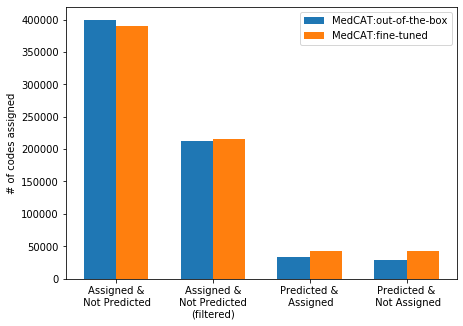

In [133]:
labels = ['Assigned &\n Not Predicted', 'Assigned &\nNot Predicted\n(filtered)', 'Predicted &\n Assigned', 'Predicted &\n Not Assigned']
indices = range(len(labels))
width = np.min(np.diff(indices))/3

fig, (ax) = plt.subplots(figsize=(7, 5))
ax.bar(indices - width / 2, y_unsupervised, width, label='MedCAT:out-of-the-box')
ax.bar(indices + width / 2, y_supervised, width, label='MedCAT:fine-tuned')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel('# of codes assigned')

ax.legend()

plt.savefig(f'./plots/aggregate_code_counts.png')
plt.show()

In [137]:
y_supervised

[389933, 216116, 42837, 42243]

In [143]:
(y_supervised[-2] + y_supervised[0])

432770

In [144]:
y_supervised[-2] / (y_supervised[-2] + y_supervised[1])

0.16542384139206728

In [142]:
 y_supervised[-2] / (y_supervised[-2] + y_supervised[0]) * 100

9.898329366638169

### Aggregate Prediction Improvements since Fine-Tuning

In [270]:
round(joined_df_fine_tuned[joined_df_fine_tuned.match == 'match'].shape[0] / joined_df[joined_df.match == 'match'].shape[0]  * 100, 2) - 100

26.299999999999997

In [373]:
joined_df_fine_tuned[joined_df_fine_tuned.match == 'match'].shape[0] - joined_df[joined_df.match == 'match'].shape[0]

9694

In [268]:
round(joined_df_fine_tuned[joined_df_fine_tuned.match == 'pred_no_assign'].shape[0] / joined_df[joined_df.match == 'pred_no_assign'].shape[0]  * 100, 2) - 100

49.81999999999999

In [374]:
joined_df_fine_tuned[joined_df_fine_tuned.match == 'pred_no_assign'].shape[0] - joined_df[joined_df.match == 'pred_no_assign'].shape[0]

16041

In [376]:
joined_df_fine_tuned[joined_df_fine_tuned.match == 'pred_no_assign'].shape[0] / joined_df_fine_tuned[joined_df_fine_tuned.match == 'assigned_no_pred'].shape[0]

0.12369917886066276

In [380]:
y_supervised[2]/ y_supervised[0]

0.11165392131218169

NameError: name 'y_supervised' is not defined

## Discussion Section Analysis

### DD Subsection Total Assigned Codes Coverage of text

In [3]:
all_annos = json.load(open('data/mimic_dd_annos_fine_tuned_cat.json'))

In [4]:
output_text = []
ents = []
text_raw = []
for doc_annos in all_annos:
    t = doc_annos['text']
    r_l = 0
    for a in doc_annos['entities']:
        start = a['start'] - r_l
        end = a['end'] - r_l
        r_l = a['end'] - a['start']
        new_t_tmp = t[:start]
        t = new_t_tmp + t[end:]
    output_text.append(t)
    text_raw.append(doc_annos['text'])
    ents.append(doc_annos['entities'])

In [5]:
coverage_df = pd.DataFrame({'text': text_raw, 'parsed_text': output_text, 'ents': ents})

In [6]:
coverage_df['parsed_text_clean'] = coverage_df.parsed_text.str.lower()\
    .str.replace('\n', '')\
    .str.replace('\,|\.|:|;|\||\[|\]|\{|\}|\||\(|\)|\*|-|"', '')\
    .str.replace('\d', '')\
    .str.replace('primary', '')\
    .str.replace('secondary', '')\
    .str.replace('diagnosis', '')

In [7]:
coverage_df['%_covered'] = round((coverage_df.text.str.len() - coverage_df.parsed_text_clean.str.len()) / coverage_df.text.str.len(), 2) * 100

In [8]:
coverage_df[coverage_df['%_covered'] == 100.0].shape

(2105, 5)

In [9]:
coverage_df['%_covered']

0         46.0
1        100.0
2         53.0
3         49.0
4         50.0
         ...  
48893     28.0
48894     86.0
48895     33.0
48896     26.0
48897     72.0
Name: %_covered, Length: 48898, dtype: float64

In [10]:
coverage_df['%_covered'].mean()

47.37932021759581

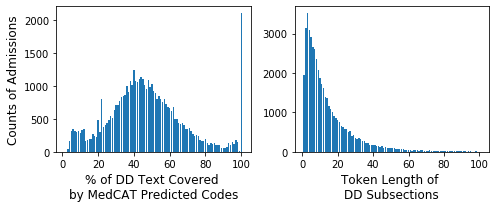

In [11]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(7, 3))
cov = coverage_df['%_covered'].value_counts().sort_index() 
ax.bar(cov.index, cov.tolist())
ax.set_xlabel('% of DD Text Covered \nby MedCAT Predicted Codes', fontsize=12)
ax.set_ylabel('Counts of Admissions', fontsize=12)

toks_len = coverage_df.text.str.split(' ').apply(len).value_counts().sort_index().iloc[0:100]
ax2.bar(toks_len.index, toks_len.tolist())
ax2.set_xlabel('Token Length of \nDD Subsections', fontsize=12)
# ax2.set_ylabel('Counts of Admissions', fontsize=12)
plt.tight_layout()
plt.savefig('plots/dd_prediction_coverage.png')
plt.show()

In [13]:
cov_len_srs = coverage_df.text.str.split(' ').apply(len)

In [14]:
print(f"Coverage Distribution: mean:{cov_len_srs.mean()}, sigma: {cov_len_srs.std()}")
print(f"Median:{cov_len_srs.median()}, IQR:{cov_len_srs.quantile(0.75) - cov_len_srs.quantile(0.25)}")

Coverage Distribution: mean:14.542169413881957, sigma: 15.903119444412367
Median:10.0, IQR:14.0


In [15]:
coverage_df['num_ents'] = coverage_df.ents.apply(len)
print(f"Entities Extracted: mean: {coverage_df.num_ents.mean()}, sigma:{coverage_df.num_ents.std()}")
print(f"Median:{coverage_df.num_ents.median()}, IQR:{coverage_df.num_ents.quantile(0.75) - coverage_df.num_ents.quantile(0.25)}")

Entities Extracted: mean: 3.6076935661990266, sigma:3.139975655480332
Median:3.0, IQR:4.0


In [12]:
coverage_df.text.str.split(' ').apply(len).median()

10.0

### Predicted and Assigned
- Distribution of HADMs that matched
- \# of matches correlation with length of DD, and discharge summary
- distribution of matches over codes
- top codes that matched

In [191]:
df_ft = joined_df_fine_tuned

In [192]:
all_assigns = df_ft[(df_ft.match == 'assigned_no_pred') | (df_ft.match == 'match')]

In [193]:
matched = df_ft[df_ft.match == 'match']
no_assn = df_ft[df_ft.match == 'assigned_no_pred']

In [194]:
h_counts_n_assn = no_assn.groupby('hadm').count().icd9
h_counts_match = matched.groupby('hadm').count().icd9

In [195]:
matched['code_group'] = matched.icd9.apply(lambda c: str(find_root_axis(search(c))).split(':')[0])

<ipython-input-195-d93ec8528509>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched['code_group'] = matched.icd9.apply(lambda c: str(find_root_axis(search(c))).split(':')[0])


#### Ranking
- via % predicted vs assigned
- via total occurrence
- via total predicted

In [197]:
no_assn.icd9.value_counts().index
matched.icd9.value_counts().index
combi_index = pd.Index.union(no_assn.icd9.value_counts().index, matched.icd9.value_counts().index)
no_assn_cd = no_assn.icd9.value_counts()
matched_cd = matched.icd9.value_counts()
no_assn_cd.reindex(combi_index, fill_value=0)
matched_cd.reindex(combi_index, fill_value=0)

00845     7
0380     13
03811     0
03842     0
03849     0
         ..
V5865     0
V5867     0
V667      0
V707      0
V8741     0
Name: icd9, Length: 400, dtype: int64

In [198]:
top_pred_codes = ((matched_cd / (matched_cd + no_assn_cd)).fillna(0) * 100).sort_values(ascending=False).head(50).reset_index()
top_pred_codes.columns = ['code', '% predicted vs assigned']
top_pred_codes['code_occur_not_matched'] = no_assn_cd[top_pred_codes.code].tolist()
top_pred_codes['code_occurr_matched'] = matched_cd[top_pred_codes.code].tolist()
top_pred_codes['toal_occurr'] = (matched_cd + no_assn_cd)[top_pred_codes.code].tolist()
rank_df = df_ft.icd9.value_counts().reset_index()
rank_df.columns = ['code', 'counts']
rank_df['icd9'] = rank_df.code.apply(str)
top_pred_codes['occurrence_rank'] = top_pred_codes.code.apply(lambda c: rank_df[rank_df.code == c].index[0])
top_pred_codes['desc'] = top_pred_codes.code.apply(lambda c: search(c).long_desc or search(c).short_desc)
top_pred_codes.head(5)

,code,% predicted vs assigned,code_occur_not_matched,code_occurr_matched,toal_occurr,occurrence_rank,desc
0,7470,69.187675,110,247,357.0,196,Patent ductus arteriosus
1,41519,59.022556,327,471,798.0,114,Other pulmonary embolism and infarction
2,7766,56.377551,171,221,392.0,246,Anemia of prematurity
3,1550,55.769231,138,174,312.0,305,"Malignant neoplasm of liver, primary"
4,5789,51.834504,617,664,1281.0,26,"Hemorrhage of gastrointestinal tract, unspecified"


In [199]:
top_pred_codes.sort_values('code_occurr_matched', ascending=False).head(5)

,code,% predicted vs assigned,code_occur_not_matched,code_occurr_matched,toal_occurr,occurrence_rank,desc
14,4019,35.949664,12012,6742,18754.0,0,Unspecified essential hypertension
8,41401,39.410730,6889,4481,11370.0,2,Coronary atherosclerosis of native coronary ar...
37,4280,24.439648,9102,2944,12046.0,1,"Congestive heart failure, unspecified"
15,5990,35.240125,3951,2150,6101.0,10,"Urinary tract infection, site not specified"
48,2724,21.970959,6556,1846,8402.0,5,Other and unspecified hyperlipidemia


In [200]:
top_pred_codes.sort_values(by='toal_occurr', ascending=False).head(5)

,code,% predicted vs assigned,code_occur_not_matched,code_occurr_matched,toal_occurr,occurrence_rank,desc
14,4019,35.949664,12012,6742,18754.0,0,Unspecified essential hypertension
37,4280,24.439648,9102,2944,12046.0,1,"Congestive heart failure, unspecified"
8,41401,39.410730,6889,4481,11370.0,2,Coronary atherosclerosis of native coronary ar...
48,2724,21.970959,6556,1846,8402.0,5,Other and unspecified hyperlipidemia
15,5990,35.240125,3951,2150,6101.0,10,"Urinary tract infection, site not specified"


#### Proportion of matched assigned codes vs number of assigned codes 

In [201]:
combi_index = pd.Index.union(h_counts_n_assn.index, h_counts_match.index)
h_counts_n_assn = h_counts_n_assn.reindex(combi_index, fill_value=0) 
h_counts_match = h_counts_match.reindex(combi_index, fill_value=0)

In [202]:
all_codes_per_hadm = h_counts_n_assn + h_counts_match

In [203]:
distribution_correct = (round(h_counts_match / all_codes_per_hadm,2) * 100).value_counts()
# remove occurrence where there are no matches
distribution_correct = distribution_correct.iloc[1:]
distribution_correct.index = [int(round(i)) for i in distribution_correct.index]

In [204]:
binned_distro = [(f'{bin_start}-{bin_start + 9}%', sum([0 if i not in distribution_correct else distribution_correct[i] for i in range(bin_start, bin_start+10)])) for bin_start in range(0, 110, 10)]
binned_distro[-1] = ('100%', binned_distro[-1][1])
binned_distro[0] = ('1-9%', binned_distro[0][1])
acph = all_codes_per_hadm.value_counts()

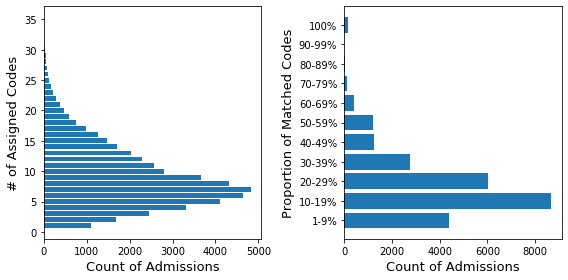

In [217]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax.barh(acph.index, acph.tolist())
ax.set_xlabel('Count of Admissions', fontsize=13)
ax.set_ylabel('# of Assigned Codes', fontsize=13)

ax2.barh([b[0] for b in binned_distro], [b[1] for b in binned_distro])
ax2.set_xlabel('Count of Admissions', fontsize=13)
ax2.set_ylabel('Proportion of Matched Codes', fontsize=13)

plt.tight_layout()
plt.savefig('plots/distribution_of_matched_compared_with_assigned_codes.png')
plt.show()

In [ ]:
100 * acph.sort_index().cumsum() / acph.sort_index().sum()

In [415]:
m_cg = matched.code_group.value_counts().sort_index().reset_index()
m_cg.columns = ['code_group', 'count']

In [416]:
m_cg['prob'] = m_cg['count'] / m_cg['count'].sum()
scipy.stats.wasserstein_distance(as_np_grouped.prob, cc.prob)

0.0026820367076930062

### Predicted and Not Assigned
- Distribution of HADMs that showed not match??
- \# of matches correlateed with length of DD, and discharge summary
- distribution of matches over codes
- top codes that matched

In [365]:
p_na = df_ft[df_ft.match == 'pred_no_assign']

In [366]:
p_na_counts = p_na.icd9.value_counts().reset_index()
p_na_counts.columns = ['code', 'count']

In [367]:
p_na_hadms = p_na.hadm.value_counts().reset_index()
p_na_hadms.columns = ['hadm', 'count']

In [368]:
dds = pd.read_csv('data/mimic_dd_icd9_sections.csv')
# print(dds[dds.name = 'Admission ID:173881'].text.iloc[0])

In [369]:
dds['len'] = dds.text.str.split('\n').apply(lambda l: len([i for i in l if len(i) > 1]))
dds['hadm'] = dds.name.str.split(':').apply(lambda l: l[1])

In [370]:
p_na_hadms.head(3)

,hadm,count
0,184752,16
1,148024,15
2,173881,15


In [371]:
dds.hadm.apply(lambda i: p_na_hadms[p_na_hadms.hadm == i])

0                         hadm  count
4675  100001      3
1                        hadm  count
16906  100003      1
2                         hadm  count
7800  100006      2
3        Empty DataFrame
Columns: [hadm, count]
Index: []
4                         hadm  count
3822  100009      3
                               ...                       
48893                     hadm  count
7633  199993      2
48894                     hadm  count
8355  199994      2
48895    Empty DataFrame
Columns: [hadm, count]
Index: []
48896    Empty DataFrame
Columns: [hadm, count]
Index: []
48897    Empty DataFrame
Columns: [hadm, count]
Index: []
Name: hadm, Length: 48898, dtype: object

In [372]:
dds = dds.drop('name', axis=1)
dds.columns = ['text', 'dd_line_len', 'hadm']

In [373]:
dds = dds.merge(p_na_hadms, on='hadm').sort_values('count', ascending=False)

In [374]:
top400_codes = set(df_ft.icd9.unique())
codes = codes[codes.icd9_code.isin(top400_codes)]
codes = codes.hadm_id.value_counts().reset_index()
codes.columns = ['hadm', 'assign_code_count']
codes['hadm'] = codes.hadm.apply(str)

In [375]:
dds = dds.merge(codes, on='hadm')

In [376]:
dds.head(5)

,text,dd_line_len,hadm,count,assign_code_count
0,\n1. Morbid obesity.\n2. Asthma.\n3. Chroni...,20,184752,16,8
1,\n1. Dysphagia.\n2. Prerenal acute renal fai...,17,148024,15,8
2,\nendometriosis\nmastoiditis\nhypothyroidism\n...,35,196904,15,10
3,\nHypoxic respiratory failure.\nProlonged wean...,19,173881,15,13
4,\nCoronary artery disease.\nCoronary stent thr...,29,129259,14,6


Stronger positive correlation with our prediction model. Suggesting those notes that have longer discharge diagnosis sections, i.e. those cases that are more complex are missing a fair amount of codes.

This makes sense as a Coder generally has a fixed amount of episodes to code, the more complex the episode the more likely something will be missed. Comment on time pressured environment etc.

In [377]:
np.corrcoef(dds.dd_line_len,  dds['count'])

array([[1.        , 0.50441746],
       [0.50441746, 1.        ]])

In [378]:
np.corrcoef(dds.dd_line_len, dds.assign_code_count,)

array([[1.        , 0.17173518],
       [0.17173518, 1.        ]])

In [379]:
p_na_counts['code_groups'] = p_na_counts.code.apply(lambda c: str(find_root_axis(search(c))).split(':')[0])
p_na_plt = p_na_counts.loc[:, ['code_groups', 'count']].groupby('code_groups').sum().sort_index()
codes = pd.read_csv('data/admission_codes.csv')
codes = codes[codes.icd9_code.isin(top400_codes)]
codes['code_groups'] = codes.icd9_code.apply(lambda c: str(find_root_axis(search(c))).split(':')[0])
code_counts = codes.code_groups.value_counts()
code_counts = code_counts.sort_index()
p_na_plt = p_na_plt.reindex(code_counts.index).fillna(0)

In [ ]:
p_na_

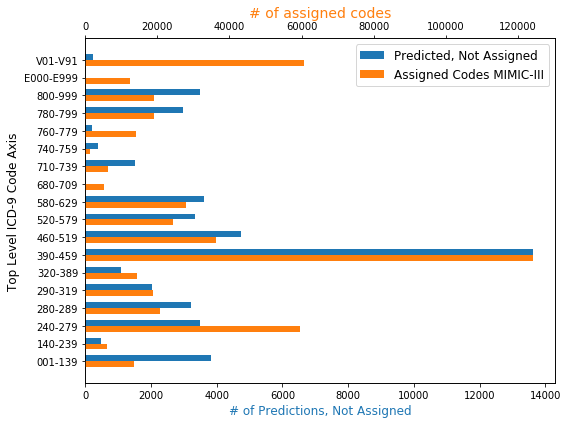

In [250]:
fig, ax = plt.subplots(figsize=(8, 6))
indices = range(len(p_na_plt['count'].tolist()))
width = np.min(np.diff(indices))/3

ax2 = ax.twiny()

color_1 = 'tab:blue'
color_2 = 'tab:orange'

bar1 = ax.barh(indices + width / 2, p_na_plt['count'].tolist(), width, label='Predicted, Not Assigned', color=color_1)
ax.set_yticks(indices)
ax.set_yticklabels(p_na_plt.index.tolist())
ax.set_ylabel('Top Level ICD-9 Code Axis', fontsize=12)
ax.set_xlabel('# of Predictions, Not Assigned', color=color_1, fontsize=12)

bar2 = bar2 = ax2.barh(indices - width / 2, code_counts.tolist(), width, label='Assigned Codes MIMIC-III', color=color_2)
ax2.set_xlabel('# of assigned codes', color=color_2, fontsize=14)

plt.legend([bar1, bar2], [bar1.get_label(), bar2.get_label()], fontsize=12)
plt.tight_layout()
plt.savefig('./plots/distribution_predicted_not_assigned.png')
plt.show()

In [251]:
codes[codes.code_groups == '001-139'].icd9_code.value_counts().reset_index().head(10)

,index,icd9_code
0,0389,3725
1,00845,1444
2,07054,1218
3,04111,703
4,07070,674
5,1120,646
6,04104,614
7,042,538
8,03811,515
9,0413,473


In [252]:
p_na_counts[p_na_counts.code_groups == '001-139'].loc[:, ['code', 'count']].groupby('code').sum().sort_values('count', ascending=False).head(10)

,count
code,
0389,3343
07070,420
0380,22
042,17
1120,16
07054,8
03811,1
07032,1


In [253]:
p_na_plt['prob'] = p_na_plt['count'] / p_na_plt['count'].sum()
cc = code_counts.reset_index()
cc.columns = ['code_groups', 'count']
cc['prob'] = cc['count'] / cc['count'].sum()
scipy.stats.wasserstein_distance(p_na_plt.prob, cc.prob)

0.01587788292311377

In [254]:
p_na_counts.loc[:, ['code', 'count']].head(10)

,code,count
0,4019,3470
1,4011,3470
2,0389,3343
3,99591,3343
4,5789,1969
5,5859,1886
6,2859,1880
7,496,1183
8,49320,1183
9,4589,1034


In [255]:
p_na_counts.head(2)

,code,count,code_groups
0,4019,3470,390-459
1,4011,3470,390-459


In [ ]:
def compute_prop(row):
    preds = p_na_counts[p_na_counts.code == row.code]
    if preds.shape[0] == 0:
        return 0
    return preds.iloc[0]['count'] / code_counts[code_counts.code == row.code]['count'].iloc[0] * 100

In [ ]:
code_counts = codes.icd9_code.value_counts().reset_index()
code_counts.columns = ['code', 'count']
code_counts['% missed'] = code_counts.apply(compute_prop, axis=1)

In [ ]:
code_counts.head(15)

In [ ]:
p_na

In [ ]:
code_counts.code

In [ ]:
codes.icd9_code.value_counts()['4019']

In [ ]:
p_na_counts['code']

#### Assigned & and Not Predicted

In [219]:
as_np = df_ft[df_ft.match == 'assigned_no_pred']

In [220]:
as_np['code_groups'] = as_np.icd9.apply(lambda c: str(find_root_axis(search(c))).split(':')[0])
as_np_grouped = as_np.code_groups.value_counts().sort_index().reset_index()
as_np_grouped.columns = ['code_groups', 'count']

<ipython-input-220-779d9059510f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  as_np['code_groups'] = as_np.icd9.apply(lambda c: str(find_root_axis(search(c))).split(':')[0])


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
indices = range(len(as_np_grouped['count'].tolist()))
width = np.min(np.diff(indices))/3

ax2 = ax.twiny()

color_1 = 'tab:blue'
color_2 = 'tab:orange'

bar1 = ax.barh(indices + width / 2, as_np_grouped['count'].tolist(), width, label='Assigned, Not Predicted', color=color_1)
ax.set_yticks(indices)
ax.set_yticklabels(as_np_grouped.code_groups.tolist())
ax.set_ylabel('Top Level ICD-9 Code Axis', fontsize=12)
ax.set_xlabel('# of Assigned, Not Predicted', color=color_1, fontsize=12)

bar2 = bar2 = ax2.barh(indices - width / 2, code_counts.tolist(), width, label='Assigned Codes MIMIC-III', color=color_2)
ax2.set_xlabel('# of assigned codes', color=color_2, fontsize=14)

plt.legend([bar1, bar2], [bar1.get_label(), bar2.get_label()], fontsize=12)
plt.tight_layout()
plt.savefig('./plots/dsitribution_assigned_and_not_predicted.png')
plt.show()

In [225]:
as_np.icd9.value_counts()

4019     12012
42731    11840
4280      9102
25000     8293
41401     6889
         ...  
340        163
V293       140
1550       138
7661       127
7470       110
Name: icd9, Length: 400, dtype: int64

In [420]:
as_np_grouped['prob'] = as_np_grouped['count'] / as_np_grouped['count'].sum()
cc = code_counts.reset_index()
cc.columns = ['code_groups', 'count']
cc['prob'] = cc['count'] / cc['count'].sum()
scipy.stats.wasserstein_distance(as_np_grouped.prob, cc.prob)

0.0026820367076930062

### Overall
- Silver Standard Clinical Coding Generation

In [324]:
p_na_d = []
assn_codes_val_counts = df_ft[(df_ft.match == 'assigned_no_pred') | (df_ft.match == 'match')].icd9.value_counts()
for g, df in p_na.groupby(['hadm', 'start']):
    if df.shape[0] == 2:
        code1_count = assn_codes_val_counts[df.icd9.iloc[0]]
        code2_count = assn_codes_val_counts[df.icd9.iloc[1]]
        if code1_count > code2_count:
            p_na_d.append(pd.DataFrame(df.iloc[0, :]).T)
        else:
            p_na_d.append(pd.DataFrame(df.iloc[1, :]).T)
    else:
        p_na_d.append(df)

In [326]:
p_na_d = pd.concat(p_na_d)

In [335]:
df_ft.match.value_counts()

assigned_no_pred    389933
pred_no_assign       48248
match                46563
Name: match, dtype: int64

In [359]:
matches = df_ft[df_ft.match == 'match'].loc[:, ['hadm', 'icd9']]
new_preds = p_na_d.loc[:, ['hadm', 'icd9']]
assn_no_pred = df_ft[df_ft.match == 'assigned_no_pred'].loc[:, ['hadm', 'icd9']]

In [360]:
matches['validated'] = 'yes' 
new_preds['validated'] = 'new_code'
assn_no_pred['validated'] = 'no'

In [395]:
pd.concat([matches, new_preds, assn_no_pred]).reset_index(drop=True).to_csv('MIMIC-III_Clinical_Codes_Silver_Standard.csv', index=False)